In [1]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import soundfile as sf
from scipy.signal import butter, lfilter
from imblearn.over_sampling import SMOTE


In [2]:
# Định nghĩa thư mục chứa dataset
DATASET_PATH = "audio_speech_actors_01-24"
FEATURES_CSV = "audio_features.csv"


In [3]:
# Duyệt qua thư mục dataset và liệt kê danh sách file
audio_files = []
for actor_folder in sorted(os.listdir(DATASET_PATH)):
    actor_path = os.path.join(DATASET_PATH, actor_folder)
    if os.path.isdir(actor_path):
        for audio_file in sorted(os.listdir(actor_path)):
            if audio_file.endswith(".wav"):
                audio_files.append(os.path.join(actor_path, audio_file))

# In ra 5 file đầu tiên để kiểm tra
print("Danh sách 5 file âm thanh đầu tiên:")
print("\n".join(audio_files[:5]))


Danh sách 5 file âm thanh đầu tiên:
audio_speech_actors_01-24\Actor_01\03-01-01-01-01-01-01.wav
audio_speech_actors_01-24\Actor_01\03-01-01-01-01-02-01.wav
audio_speech_actors_01-24\Actor_01\03-01-01-01-02-01-01.wav
audio_speech_actors_01-24\Actor_01\03-01-01-01-02-02-01.wav
audio_speech_actors_01-24\Actor_01\03-01-02-01-01-01-01.wav


C:\Users\trans\AppData\Local\Temp\ipykernel_10888\4200399290.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counter.keys()), y=list(counter.values()), ax=axes[i], palette="viridis")
C:\Users\trans\AppData\Local\Temp\ipykernel_10888\4200399290.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counter.keys()), y=list(counter.values()), ax=axes[i], palette="viridis")
C:\Users\trans\AppData\Local\Temp\ipykernel_10888\4200399290.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counter.keys()), y=list(counter.valu

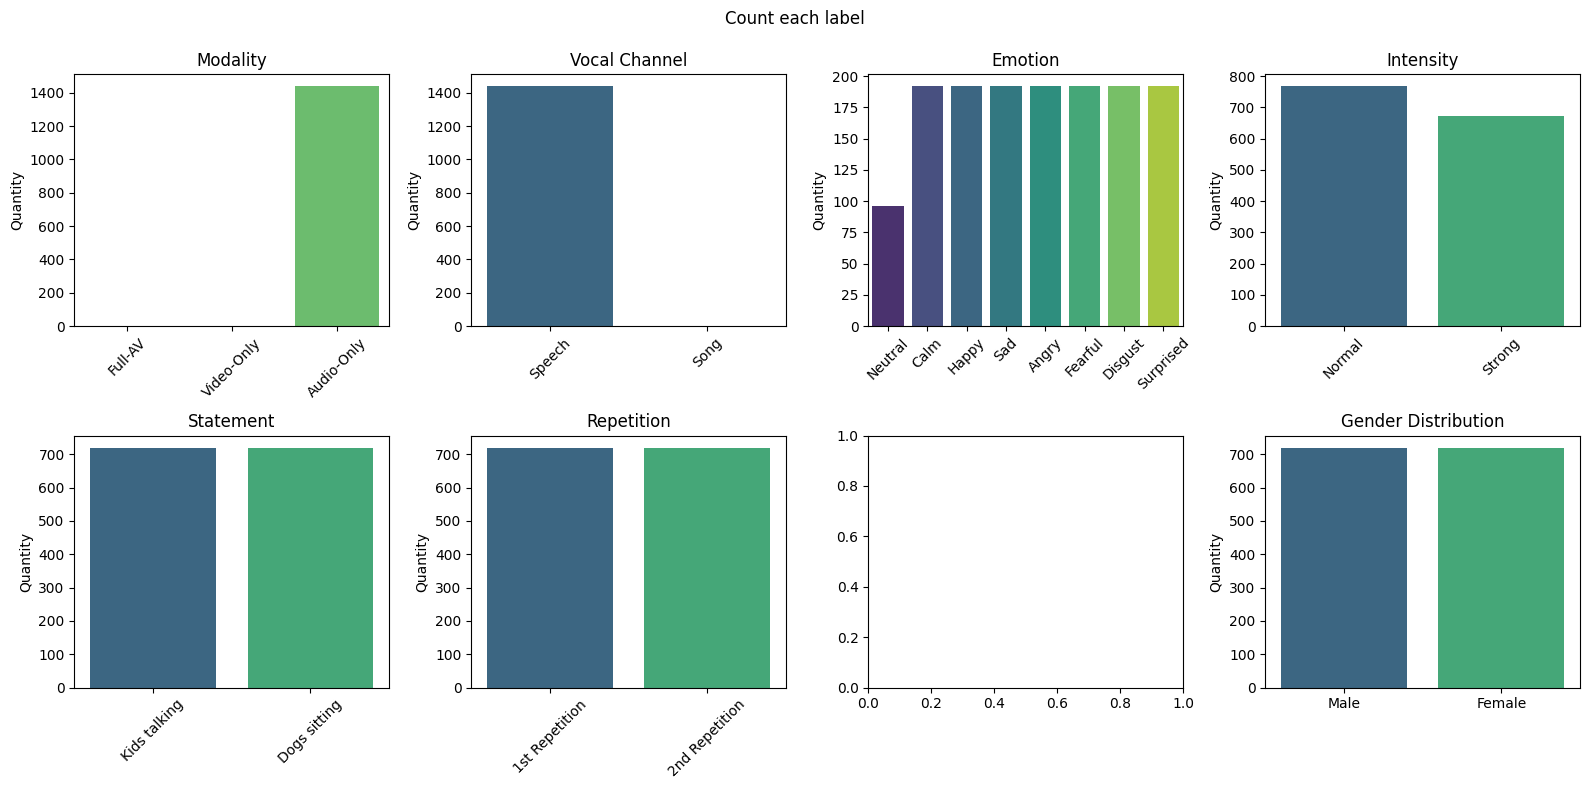

In [4]:

# Đường dẫn thư mục gốc chứa các thư mục Actor_X
data_dir = "audio_speech_actors_01-24"

# Mapping giá trị số sang tên nhãn
modality_map = {"01": "Full-AV", "02": "Video-Only", "03": "Audio-Only"}
vocal_channel_map = {"01": "Speech", "02": "Song"}
emotion_map = {"01": "Neutral", "02": "Calm", "03": "Happy", "04": "Sad", "05": "Angry", "06": "Fearful", "07": "Disgust", "08": "Surprised"}
intensity_map = {"01": "Normal", "02": "Strong"}
statement_map = {"01": "Kids talking", "02": "Dogs sitting"}
repetition_map = {"01": "1st Repetition", "02": "2nd Repetition"}
gender_map = {"Male": 0, "Female": 0}  # Đếm số lượng theo giới tính

# Khởi tạo bộ đếm cho từng nhãn (a, b, c, d, e, f)
labels_count = {
    "Modality": Counter(modality_map.values()),
    "Vocal Channel": Counter(vocal_channel_map.values()),
    "Emotion": Counter(emotion_map.values()),
    "Intensity": Counter(intensity_map.values()),
    "Statement": Counter(statement_map.values()),
    "Repetition": Counter(repetition_map.values()),
}

# Đặt giá trị mặc định là 0
for key in labels_count:
    for sub_key in labels_count[key]:
        labels_count[key][sub_key] = 0

# Duyệt qua các thư mục Actor_X
for actor_folder in os.listdir(data_dir):
    actor_path = os.path.join(data_dir, actor_folder)
    if os.path.isdir(actor_path):
        for file_name in os.listdir(actor_path):
            if file_name.endswith(".wav"):  # Kiểm tra định dạng file
                parts = file_name.replace(".wav", "").split("-")
                if len(parts) == 7:  # Đảm bảo file có đủ 7 phần theo format
                    labels_count["Modality"][modality_map[parts[0]]] += 1
                    labels_count["Vocal Channel"][vocal_channel_map[parts[1]]] += 1
                    labels_count["Emotion"][emotion_map[parts[2]]] += 1
                    labels_count["Intensity"][intensity_map.get(parts[3], "Normal")] += 1
                    labels_count["Statement"][statement_map[parts[4]]] += 1
                    labels_count["Repetition"][repetition_map[parts[5]]] += 1

                    # Xác định giới tính
                    actor_id = int(parts[6])
                    gender = "Male" if actor_id % 2 == 1 else "Female"
                    gender_map[gender] += 1

# Vẽ biểu đồ cột
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Count each label")
axes = axes.flatten()

for i, (label, counter) in enumerate(labels_count.items()):
    sns.barplot(x=list(counter.keys()), y=list(counter.values()), ax=axes[i], palette="viridis")
    axes[i].set_title(f"{label}")
    axes[i].set_ylabel("Quantity")
    axes[i].tick_params(axis='x', rotation=45)

# Vẽ biểu đồ giới tính
sns.barplot(x=list(gender_map.keys()), y=list(gender_map.values()), ax=axes[-1], palette="viridis")
axes[-1].set_title("Gender Distribution")
axes[-1].set_ylabel("Quantity")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [5]:


# Đường dẫn thư mục gốc chứa các thư mục Actor_X
data_dir = "audio_speech_actors_01-24"
output_dir = "cleaned_audio"
os.makedirs(output_dir, exist_ok=True)

# Hàm áp dụng bộ lọc High-pass để loại bỏ nhiễu tần số thấp
def highpass_filter(y, sr, cutoff=100):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(1, normal_cutoff, btype='high', analog=False)
    return lfilter(b, a, y)

# Xử lý từng file âm thanh
for actor_folder in os.listdir(data_dir):
    actor_path = os.path.join(data_dir, actor_folder)
    output_actor_path = os.path.join(output_dir, actor_folder)
    os.makedirs(output_actor_path, exist_ok=True)

    if os.path.isdir(actor_path):
        for file_name in os.listdir(actor_path):
            if file_name.endswith(".wav"):  # Kiểm tra định dạng file
                file_path = os.path.join(actor_path, file_name)
                output_file_path = os.path.join(output_actor_path, file_name)

                # Đọc file âm thanh
                y, sr = librosa.load(file_path, sr=16000)  # Đọc với tần số mẫu cố định

                # Chuẩn hóa biên độ về [-1, 1]
                y = librosa.util.normalize(y)

                # Áp dụng bộ lọc High-pass để loại bỏ nhiễu nền
                y = highpass_filter(y, sr)

                # Chuẩn hóa độ dài về 3 giây (padding hoặc trimming)
                target_length = sr * 3  # 3 giây
                if len(y) < target_length:
                    y = np.pad(y, (0, target_length - len(y)))
                else:
                    y = y[:target_length]

                # Lưu file đã làm sạch
                sf.write(output_file_path, y, sr)
                print(f"Đã xử lý: {output_file_path}")

print("Hoàn tất làm sạch dữ liệu âm thanh!")


Đã xử lý: cleaned_audio\Actor_01\03-01-01-01-01-01-01.wav
Đã xử lý: cleaned_audio\Actor_01\03-01-01-01-01-02-01.wav
Đã xử lý: cleaned_audio\Actor_01\03-01-01-01-02-01-01.wav
Đã xử lý: cleaned_audio\Actor_01\03-01-01-01-02-02-01.wav
Đã xử lý: cleaned_audio\Actor_01\03-01-02-01-01-01-01.wav
Đã xử lý: cleaned_audio\Actor_01\03-01-02-01-01-02-01.wav
Đã xử lý: cleaned_audio\Actor_01\03-01-02-01-02-01-01.wav
Đã xử lý: cleaned_audio\Actor_01\03-01-02-01-02-02-01.wav
Đã xử lý: cleaned_audio\Actor_01\03-01-02-02-01-01-01.wav
Đã xử lý: cleaned_audio\Actor_01\03-01-02-02-01-02-01.wav
Đã xử lý: cleaned_audio\Actor_01\03-01-02-02-02-01-01.wav
Đã xử lý: cleaned_audio\Actor_01\03-01-02-02-02-02-01.wav
Đã xử lý: cleaned_audio\Actor_01\03-01-03-01-01-01-01.wav
Đã xử lý: cleaned_audio\Actor_01\03-01-03-01-01-02-01.wav
Đã xử lý: cleaned_audio\Actor_01\03-01-03-01-02-01-01.wav
Đã xử lý: cleaned_audio\Actor_01\03-01-03-01-02-02-01.wav
Đã xử lý: cleaned_audio\Actor_01\03-01-03-02-01-01-01.wav
Đã xử lý: clea

In [6]:


# Đường dẫn thư mục gốc chứa các thư mục Actor_X
data_dir = "cleaned_audio"

# Hàm trích xuất đặc trưng âm thanh
def extract_features(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    return mfccs.mean(axis=1), chroma.mean(axis=1), spectral_contrast.mean(axis=1)

# Danh sách lưu trữ đặc trưng
features_list = []

# Xử lý từng file âm thanh
for actor_folder in os.listdir(data_dir):
    actor_path = os.path.join(data_dir, actor_folder)

    if os.path.isdir(actor_path):
        for file_name in os.listdir(actor_path):
            if file_name.endswith(".wav"):  # Kiểm tra định dạng file
                file_path = os.path.join(actor_path, file_name)

                # Đọc file âm thanh
                y, sr = librosa.load(file_path, sr=16000)  # Đọc với tần số mẫu cố định

                # Trích xuất đặc trưng âm thanh
                mfccs, chroma, spectral_contrast = extract_features(y, sr)

                # Lưu vào danh sách
                features_list.append([file_name] + list(mfccs) + list(chroma) + list(spectral_contrast))

                print(f"Đã trích xuất đặc trưng: {file_path}")

# Chuyển danh sách thành DataFrame và lưu vào CSV
columns = ["file_name"] + [f"mfcc_{i}" for i in range(13)] + [f"chroma_{i}" for i in range(12)] + [f"spectral_contrast_{i}" for i in range(7)]
df_features = pd.DataFrame(features_list, columns=columns)
df_features.to_csv("extracted_features.csv", index=False)

print("Hoàn tất trích xuất đặc trưng âm thanh!")


Đã trích xuất đặc trưng: cleaned_audio\Actor_01\03-01-01-01-01-01-01.wav
Đã trích xuất đặc trưng: cleaned_audio\Actor_01\03-01-01-01-01-02-01.wav
Đã trích xuất đặc trưng: cleaned_audio\Actor_01\03-01-01-01-02-01-01.wav
Đã trích xuất đặc trưng: cleaned_audio\Actor_01\03-01-01-01-02-02-01.wav
Đã trích xuất đặc trưng: cleaned_audio\Actor_01\03-01-02-01-01-01-01.wav
Đã trích xuất đặc trưng: cleaned_audio\Actor_01\03-01-02-01-01-02-01.wav
Đã trích xuất đặc trưng: cleaned_audio\Actor_01\03-01-02-01-02-01-01.wav
Đã trích xuất đặc trưng: cleaned_audio\Actor_01\03-01-02-01-02-02-01.wav
Đã trích xuất đặc trưng: cleaned_audio\Actor_01\03-01-02-02-01-01-01.wav
Đã trích xuất đặc trưng: cleaned_audio\Actor_01\03-01-02-02-01-02-01.wav
Đã trích xuất đặc trưng: cleaned_audio\Actor_01\03-01-02-02-02-01-01.wav
Đã trích xuất đặc trưng: cleaned_audio\Actor_01\03-01-02-02-02-02-01.wav
Đã trích xuất đặc trưng: cleaned_audio\Actor_01\03-01-03-01-01-01-01.wav
Đã trích xuất đặc trưng: cleaned_audio\Actor_01\03-

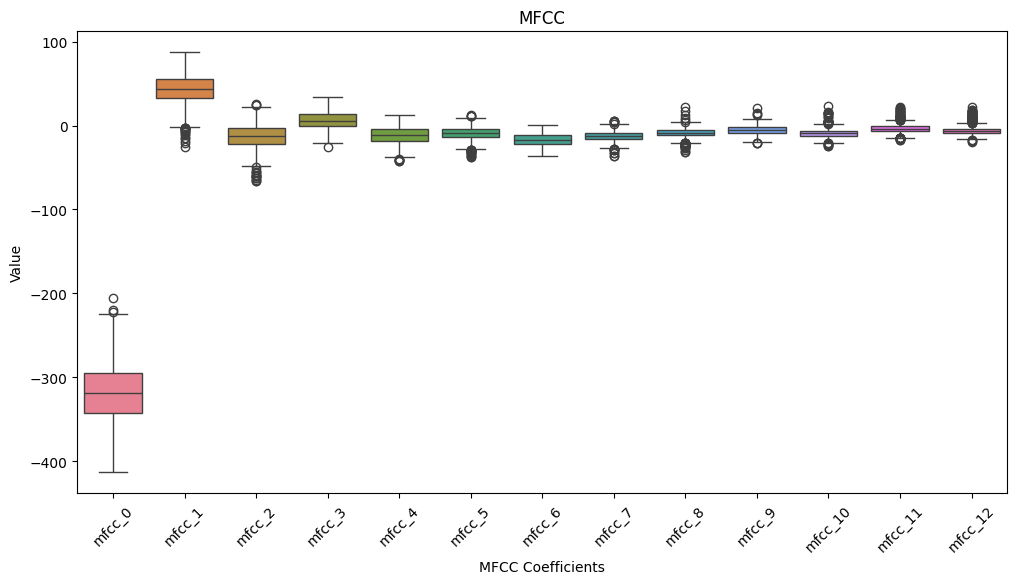

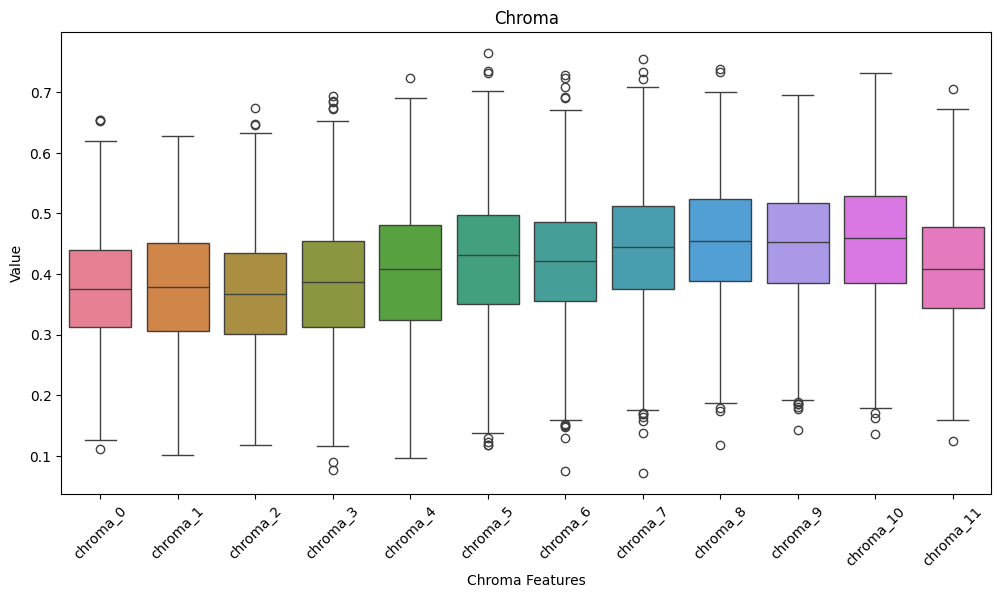

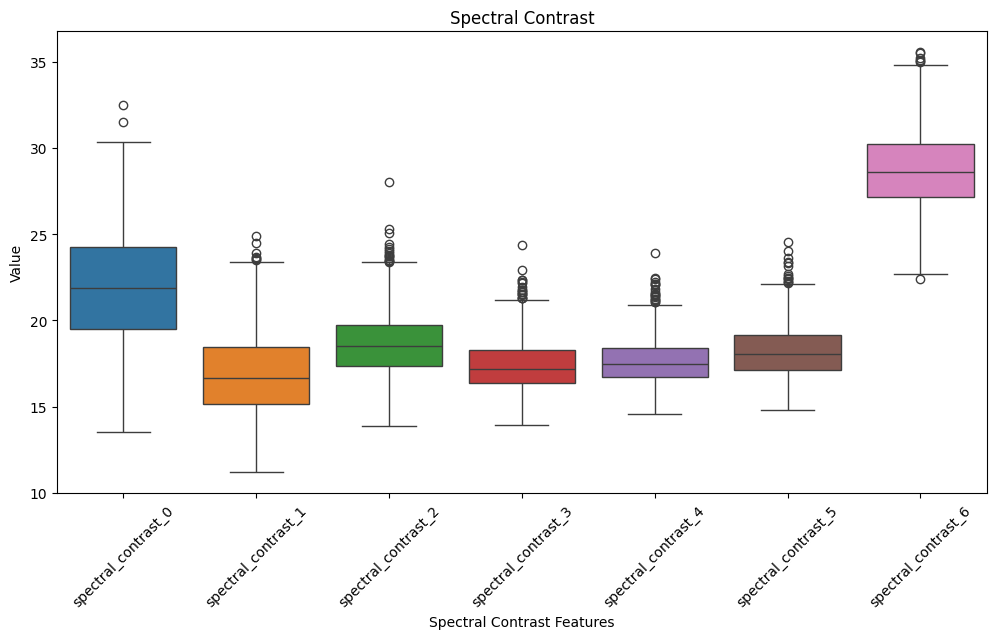

Hoàn tất trực quan hóa đặc trưng âm thanh!


In [7]:

# Đọc dữ liệu đặc trưng từ file CSV
df_features = pd.read_csv("extracted_features.csv")

# Vẽ biểu đồ boxplot cho các đặc trưng MFCC
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_features.iloc[:, 1:14])  # Cột MFCC
plt.title("MFCC")
plt.xlabel("MFCC Coefficients")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()

# Vẽ biểu đồ boxplot cho đặc trưng Chroma
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_features.iloc[:, 14:26])  # Cột Chroma
plt.title("Chroma")
plt.xlabel("Chroma Features")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()

# Vẽ biểu đồ boxplot cho đặc trưng Spectral Contrast
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_features.iloc[:, 26:])  # Cột Spectral Contrast
plt.title("Spectral Contrast")
plt.xlabel("Spectral Contrast Features")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()

print("Hoàn tất trực quan hóa đặc trưng âm thanh!")


<Figure size 1500x1000 with 0 Axes>

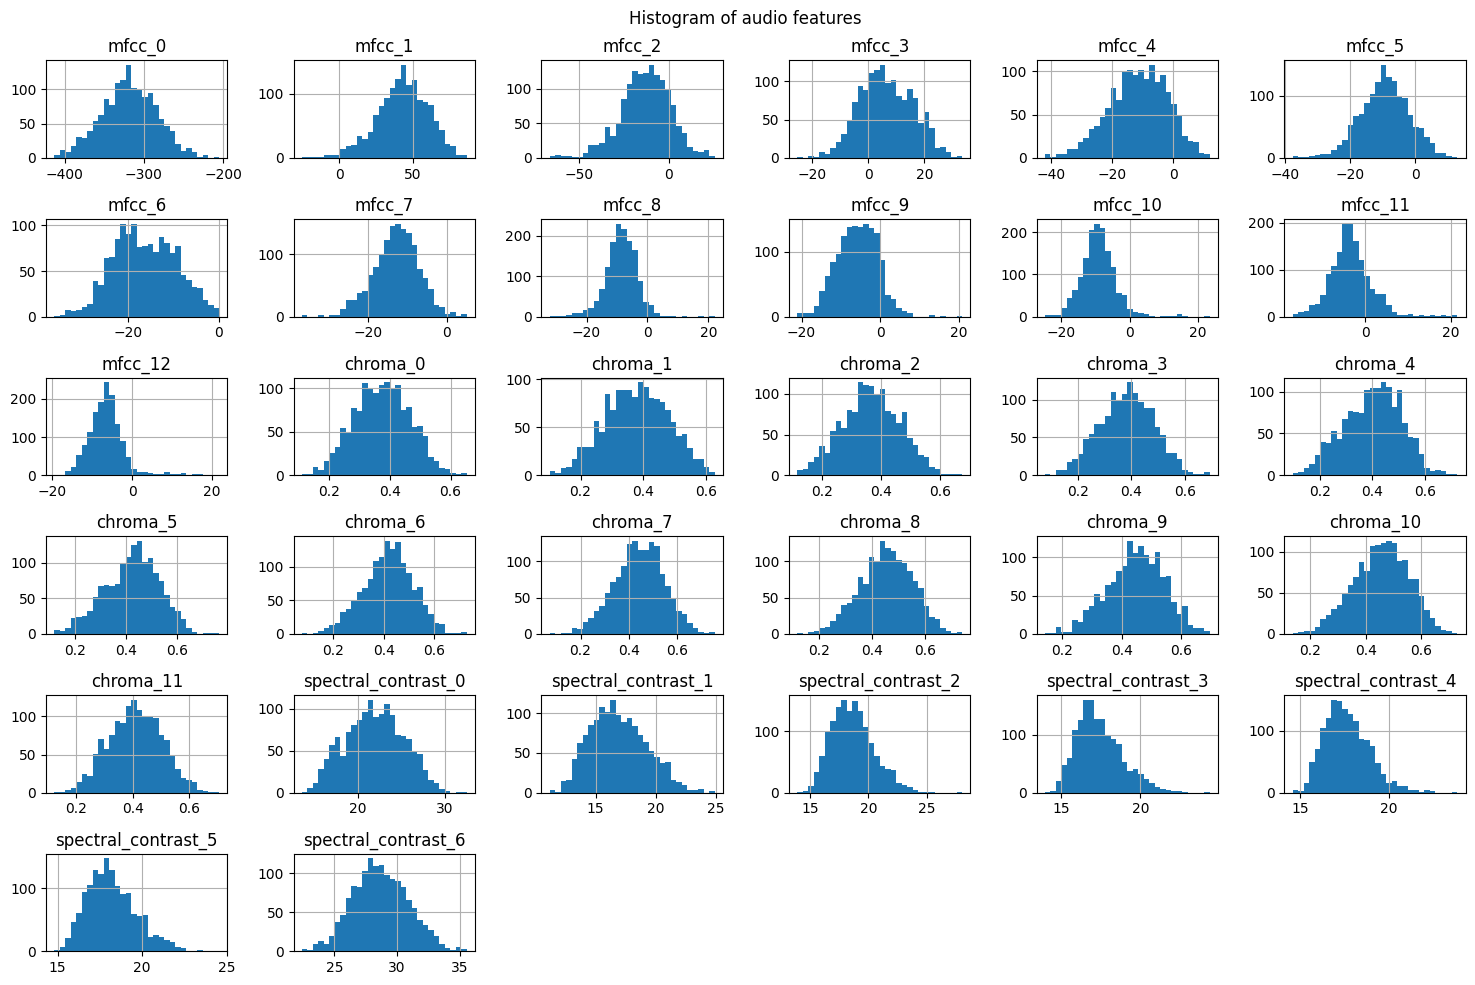

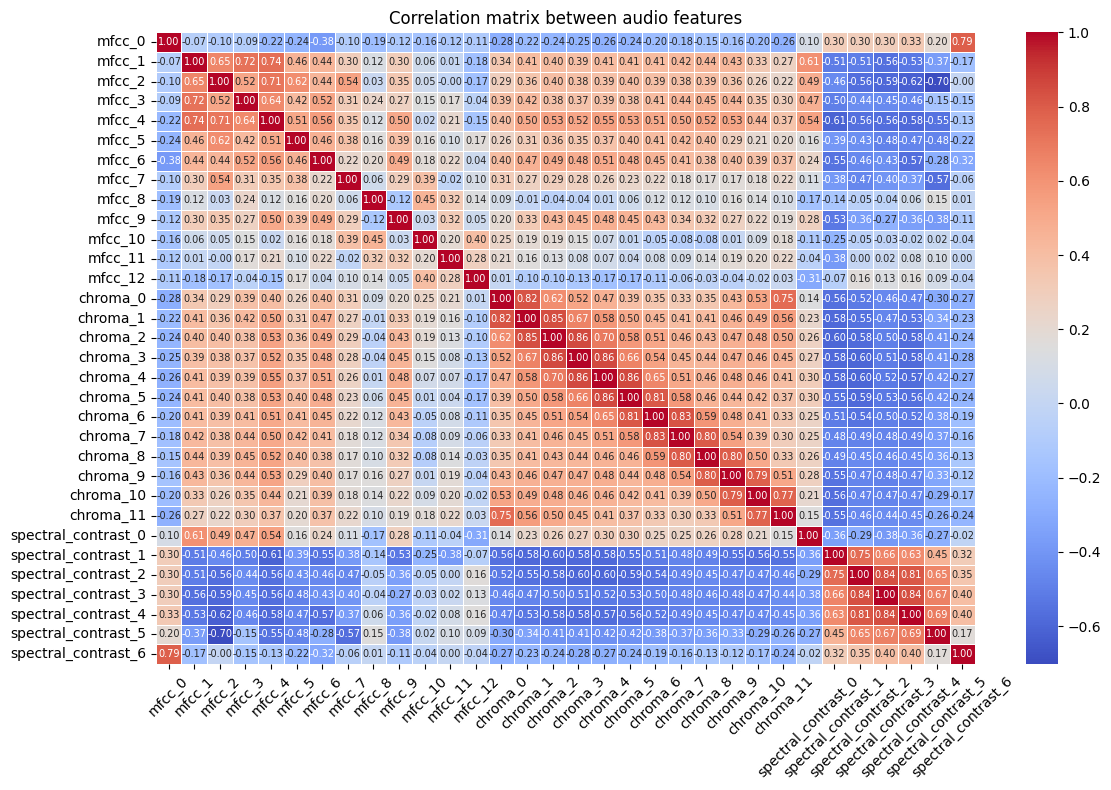

In [8]:


# Đọc dữ liệu đặc trưng từ file CSV
df_features = pd.read_csv("extracted_features.csv")

# Vẽ histogram cho từng đặc trưng

plt.figure(figsize=(15, 10))
df_features.iloc[:, 1:].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histogram of audio features")
plt.tight_layout()  # Tự động điều chỉnh khoảng cách để tránh chồng chữ
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df_features.iloc[:, 1:].corr(),
            annot=True,
            cmap="coolwarm",
            fmt=".2f",
            linewidths=0.5,
            annot_kws={"size": 7})  # Giảm kích thước chữ số
plt.title("Correlation matrix between audio features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



C:\Users\trans\AppData\Local\Temp\ipykernel_10888\1392512408.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_features[label_column], palette="viridis", order=emotion_map.values())


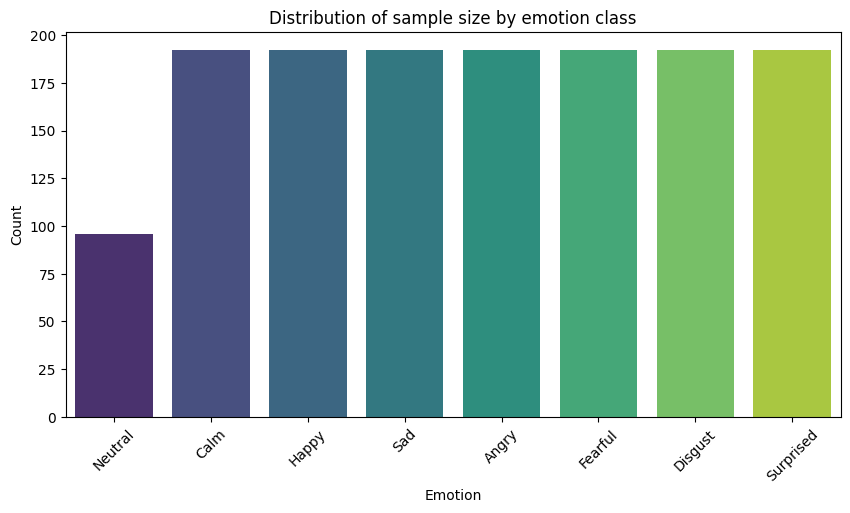

c:\Users\trans\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\trans\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\trans\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\trans\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

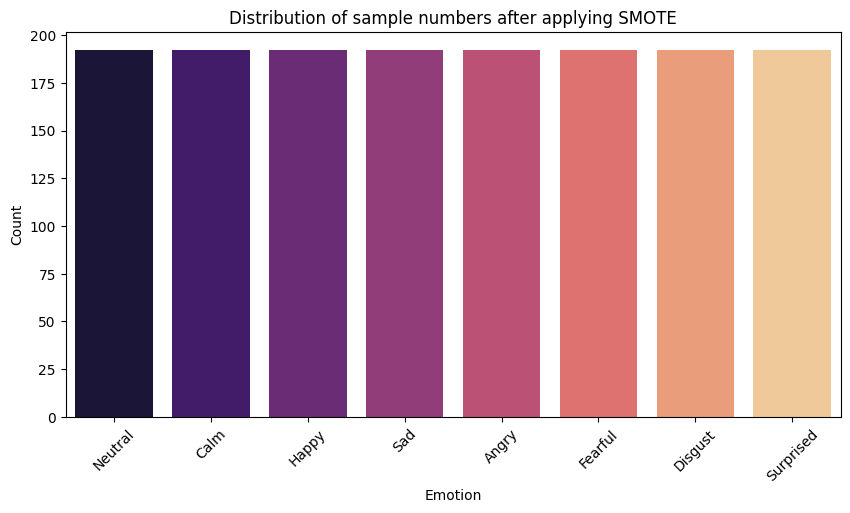

Hoàn tất cân bằng dữ liệu bằng SMOTE!


In [9]:


# Đọc dữ liệu đặc trưng từ file CSV
df_features = pd.read_csv("extracted_features.csv")

# Định nghĩa mapping cho nhãn cảm xúc
emotion_map = {
    1: "Neutral",
    2: "Calm",
    3: "Happy",
    4: "Sad",
    5: "Angry",
    6: "Fearful",
    7: "Disgust",
    8: "Surprised"
}

# Giả sử cột 'label' chứa nhãn cảm xúc (Emotion)
label_column = 'label'  # Cần thay thế bằng tên thực tế nếu khác
df_features[label_column] = df_features['file_name'].apply(lambda x: int(x.split('-')[2]))
df_features[label_column] = df_features[label_column].map(emotion_map)

# Kiểm tra phân phối lớp
plt.figure(figsize=(10, 5))
sns.countplot(x=df_features[label_column], palette="viridis", order=emotion_map.values())
plt.title("Distribution of sample size by emotion class")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Áp dụng SMOTE để cân bằng dữ liệu
X = df_features.iloc[:, 1:-1]  # Các đặc trưng
y = df_features[label_column]   # Nhãn cảm xúc

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Chuyển dữ liệu đã cân bằng thành DataFrame mới
df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced[label_column] = y_resampled

# Kiểm tra lại phân phối lớp sau khi cân bằng
plt.figure(figsize=(10, 5))
sns.countplot(x=df_balanced[label_column], palette="magma", order=emotion_map.values())
plt.title("Distribution of sample numbers after applying SMOTE")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Lưu dữ liệu đã cân bằng
df_balanced.to_csv("balanced_features.csv", index=False)

print("Hoàn tất cân bằng dữ liệu bằng SMOTE!")


In [10]:
df_features.columns

Index(['file_name', 'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5',
       'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12',
       'chroma_0', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5',
       'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10',
       'chroma_11', 'spectral_contrast_0', 'spectral_contrast_1',
       'spectral_contrast_2', 'spectral_contrast_3', 'spectral_contrast_4',
       'spectral_contrast_5', 'spectral_contrast_6', 'label'],
      dtype='object')

C:\Users\trans\AppData\Local\Temp\ipykernel_10888\142959843.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_features["intensity"], palette="coolwarm")


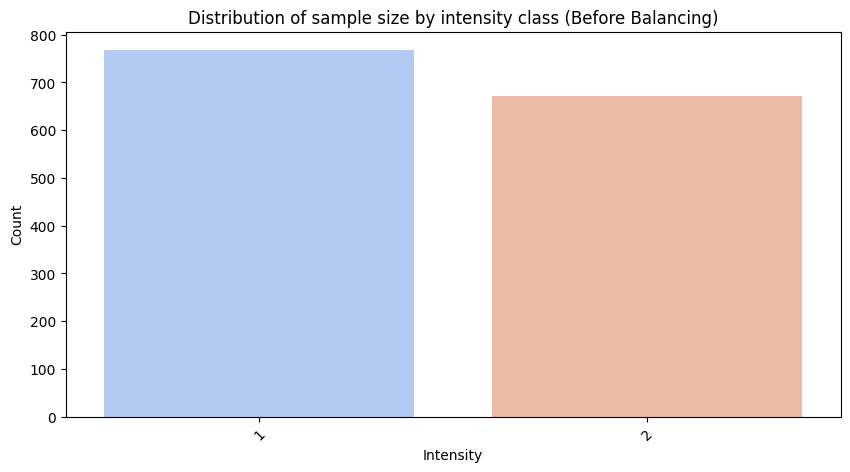

C:\Users\trans\AppData\Local\Temp\ipykernel_10888\142959843.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_balanced["intensity"], palette="plasma")


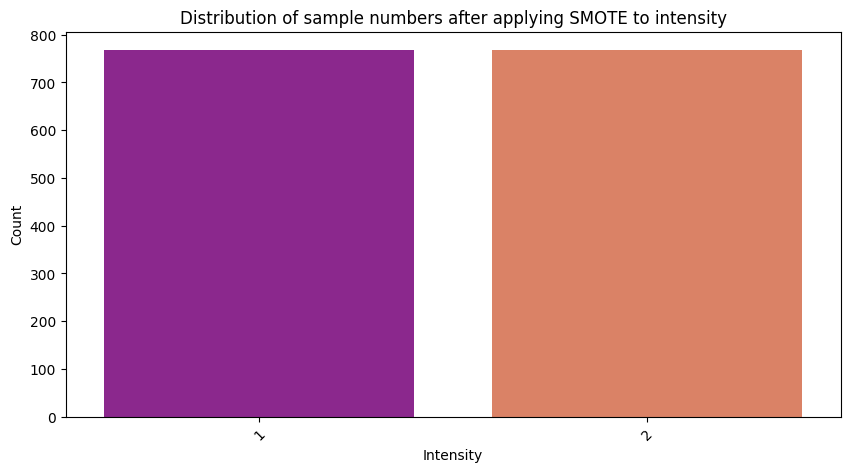

Hoàn tất cân bằng dữ liệu intensity bằng SMOTE!


In [11]:
# intensity ở vị trí thứ 4 trong data
df_features['intensity'] = df_features['file_name'].apply(lambda x: int(x.split('-')[3]))

# Vẽ biểu đồ phân phối intensity trước khi cân bằng
plt.figure(figsize=(10, 5))
sns.countplot(x=df_features["intensity"], palette="coolwarm")
plt.title("Distribution of sample size by intensity class (Before Balancing)")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Loại bỏ cột không phải đặc trưng (label) trước khi SMOTE
X_intensity = df_features.drop(columns=["intensity", "file_name", "label"])  # Xóa cột không cần thiết
y_intensity = df_features["intensity"]  # Nhãn intensity

# Kiểm tra giá trị NaN trong X trước khi SMOTE
if X_intensity.isnull().sum().sum() > 0:
    print("Dữ liệu có NaN, xử lý trước khi SMOTE...")
    X_intensity.fillna(X_intensity.mean(), inplace=True)  # Điền giá trị trung bình

# Áp dụng SMOTE
smote_intensity = SMOTE(random_state=42)
X_resampled_intensity, y_resampled_intensity = smote_intensity.fit_resample(X_intensity, y_intensity)

# Chuyển dữ liệu đã cân bằng thành DataFrame mới
df_balanced = pd.DataFrame(X_resampled_intensity, columns=X_intensity.columns)
df_balanced["intensity"] = y_resampled_intensity

# Kiểm tra phân phối lớp intensity sau khi cân bằng
plt.figure(figsize=(10, 5))
sns.countplot(x=df_balanced["intensity"], palette="plasma")
plt.title("Distribution of sample numbers after applying SMOTE to intensity")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Lưu dữ liệu đã cân bằng
df_balanced.to_csv("balanced_intensity_features.csv", index=False)

print("Hoàn tất cân bằng dữ liệu intensity bằng SMOTE!")

In [12]:

# Đọc dữ liệu đặc trưng đã cân bằng
balanced_df = pd.read_csv("balanced_features.csv")

# Định nghĩa cột nhãn cảm xúc
label_column = "label"

# Tạo ánh xạ đặc trưng - nhãn
feature_label_map = {}
for emotion in balanced_df[label_column].unique():
    feature_label_map[emotion] = balanced_df[balanced_df[label_column] == emotion].iloc[:, :-1].values

# Lưu ánh xạ vào tệp numpy
np.save("feature_label_mapping.npy", feature_label_map)

print("Đã tạo và lưu ánh xạ đặc trưng - nhãn!")


Đã tạo và lưu ánh xạ đặc trưng - nhãn!


C:\Users\trans\AppData\Local\Temp\ipykernel_10888\1301781073.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts["Emotion"], y=emotion_counts["Count"], palette="coolwarm")


     Emotion  Count
0    Neutral    192
1       Calm    192
2      Happy    192
3        Sad    192
4      Angry    192
5    Fearful    192
6    Disgust    192
7  Surprised    192


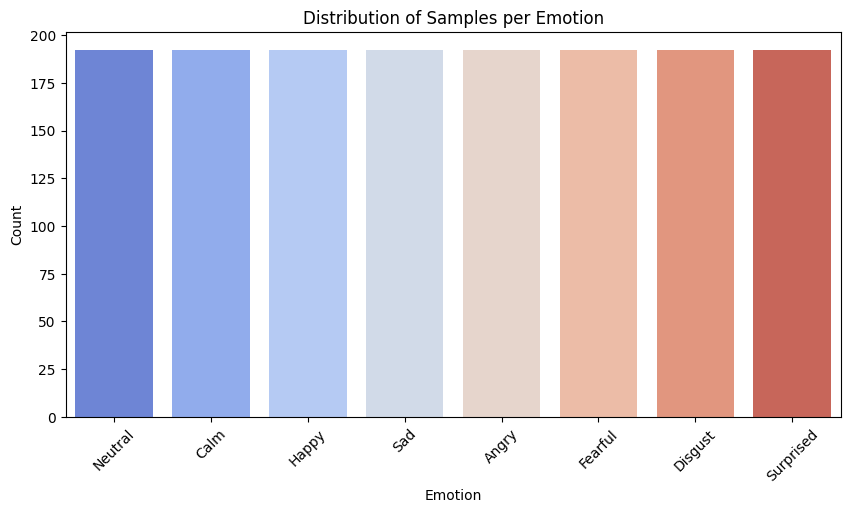

Đã tạo, lưu và trực quan hóa ánh xạ đặc trưng - nhãn!


In [13]:
# Đọc dữ liệu đặc trưng đã cân bằng
balanced_df = pd.read_csv("balanced_features.csv")

# Định nghĩa cột nhãn cảm xúc
label_column = "label"

# Tạo ánh xạ đặc trưng - nhãn
feature_label_map = {}
for emotion in balanced_df[label_column].unique():
    feature_label_map[emotion] = balanced_df[balanced_df[label_column] == emotion].iloc[:, :-1].values

# Lưu ánh xạ vào tệp numpy
np.save("feature_label_mapping.npy", feature_label_map)

# Hiển thị bảng thống kê số lượng mẫu cho từng cảm xúc
emotion_counts = balanced_df[label_column].value_counts().reset_index()
emotion_counts.columns = ["Emotion", "Count"]
print(emotion_counts)

# Vẽ biểu đồ thể hiện số lượng mẫu của từng cảm xúc
plt.figure(figsize=(10, 5))
sns.barplot(x=emotion_counts["Emotion"], y=emotion_counts["Count"], palette="coolwarm")
plt.title("Distribution of Samples per Emotion")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

print("Đã tạo, lưu và trực quan hóa ánh xạ đặc trưng - nhãn!")

In [ ]:
import os
import librosa
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import Counter

# Đường dẫn dataset RAVDESS
DATASET_PATH = "audio_speech_actors_01-24"

# Hàm tăng cường dữ liệu với tùy chỉnh theo lớp
def augment_audio(y, sr, emotion):
    augmentations = [y]  # Bản gốc
    if emotion in [0, 3]:  # "neutral" và "sad" - tăng augmentation
        augmentations.append(y + np.random.randn(len(y)) * 0.005)  # Nhiễu nhẹ
        augmentations.append(y + np.random.randn(len(y)) * 0.01)   # Nhiễu trung bình
        augmentations.append(y + np.random.randn(len(y)) * 0.015)  # Nhiễu mạnh
        augmentations.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=2))  # Cao độ
        augmentations.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=-2)) # Cao độ ngược
        augmentations.append(librosa.effects.time_stretch(y, rate=1.1))  # Kéo dài
        augmentations.append(librosa.effects.time_stretch(y, rate=0.9))  # Nén
        augmentations.append(y * np.random.uniform(0.7, 1.3))  # Âm lượng
    elif emotion == 6:  # "disgust"
        augmentations.append(y + np.random.randn(len(y)) * 0.005)  # Nhiễu nhẹ
        augmentations.append(y + np.random.randn(len(y)) * 0.01)   # Nhiễu trung bình
        augmentations.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=1))  # Cao độ nhẹ
        augmentations.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=-1)) # Cao độ ngược
        augmentations.append(librosa.effects.time_stretch(y, rate=1.1))  # Kéo dài
        augmentations.append(y * np.random.uniform(0.8, 1.2))  # Âm lượng
    else:  # Các lớp khác
        augmentations.append(y + np.random.randn(len(y)) * 0.005)  # Nhiễu nhẹ
        augmentations.append(y + np.random.randn(len(y)) * 0.01)   # Nhiễu trung bình
        augmentations.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=2))  # Cao độ
        augmentations.append(librosa.effects.time_stretch(y, rate=1.1))  # Kéo dài
        augmentations.append(y * np.random.uniform(0.8, 1.2))  # Âm lượng
    return augmentations

# Hàm trích xuất MFCCs, RMS, ZCR, Spectral Centroid, và Spectral Contrast
def extract_features(file_path, emotion, max_length=150, n_mfcc=20):
    try:
        print(f"Processing file: {file_path}")
        y, sr = librosa.load(file_path, sr=22050)
        y = librosa.util.normalize(y)
        augmented_data = augment_audio(y, sr, emotion)
        features = []
        for i, audio in enumerate(augmented_data):
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
            rms = librosa.feature.rms(y=audio)
            zcr = librosa.feature.zero_crossing_rate(y=audio)
            spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
            spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)  # Thêm Spectral Contrast (7 bands mặc định)
            combined = np.concatenate((mfcc, rms, zcr, spectral_centroid, spectral_contrast), axis=0)
            if combined.shape[1] > max_length:
                combined = combined[:, :max_length]
            else:
                combined = np.pad(combined, ((0, 0), (0, max_length - combined.shape[1])), mode="constant")
            features.append(combined)
        return np.array(features)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.array([])

# Chuẩn bị và lưu dữ liệu
audio_files = []
labels = []
for actor_folder in sorted(os.listdir(DATASET_PATH)):
    actor_path = os.path.join(DATASET_PATH, actor_folder)
    if os.path.isdir(actor_path):
        print(f"Scanning folder: {actor_path}")
        for audio_file in sorted(os.listdir(actor_path)):
            if audio_file.endswith(".wav"):
                file_path = os.path.join(actor_path, audio_file)
                emotion = int(audio_file.split("-")[2]) - 1  # 0-indexed
                audio_files.append(file_path)
                labels.append(emotion)

X = []
y = []
for file, label in zip(audio_files, labels):
    features = extract_features(file, label)
    if features.size > 0:
        X.extend(features)
        y.extend([label] * len(features))
        print(f"Added {len(features)} feature sequences for label {label}")

X = np.array(X)
y = np.array(y)

if X.size == 0:
    raise ValueError("No valid data extracted. Check dataset path or files.")

print(f"Total X shape: {X.shape}, Total y shape: {y.shape}")
print("Class distribution:", Counter(y))

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[1] * X.shape[2])
X_normalized = scaler.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

joblib.dump(scaler, "scaler.pkl")
print("Scaler saved to 'scaler.pkl'")

# Lưu dữ liệu thô
np.save("X_raw.npy", X)
np.save("y_raw.npy", y)
print("Raw data saved to 'X_raw.npy' and 'y_raw.npy'")

# Chia dữ liệu 80/10/10
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Lưu các tập dữ liệu
np.save("X_train.npy", X_train)
np.save("X_val.npy", X_val)
np.save("X_test.npy", X_test)
np.save("y_train.npy", y_train)
np.save("y_val.npy", y_val)
np.save("y_test.npy", y_test)
print("Data splits saved to 'X_train.npy', 'X_val.npy', 'X_test.npy', 'y_train.npy', 'y_val.npy', 'y_test.npy'")

Scanning folder: audio_speech_actors_01-24\Actor_01
Scanning folder: audio_speech_actors_01-24\Actor_02
Scanning folder: audio_speech_actors_01-24\Actor_03
Scanning folder: audio_speech_actors_01-24\Actor_04
Scanning folder: audio_speech_actors_01-24\Actor_05
Scanning folder: audio_speech_actors_01-24\Actor_06
Scanning folder: audio_speech_actors_01-24\Actor_07
Scanning folder: audio_speech_actors_01-24\Actor_08
Scanning folder: audio_speech_actors_01-24\Actor_09
Scanning folder: audio_speech_actors_01-24\Actor_10
Scanning folder: audio_speech_actors_01-24\Actor_11
Scanning folder: audio_speech_actors_01-24\Actor_12
Scanning folder: audio_speech_actors_01-24\Actor_13
Scanning folder: audio_speech_actors_01-24\Actor_14
Scanning folder: audio_speech_actors_01-24\Actor_15
Scanning folder: audio_speech_actors_01-24\Actor_16
Scanning folder: audio_speech_actors_01-24\Actor_17
Scanning folder: audio_speech_actors_01-24\Actor_18
Scanning folder: audio_speech_actors_01-24\Actor_19
Scanning fol

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


Trial 10 Complete [00h 00m 55s]
val_accuracy: 0.3010309338569641

Best val_accuracy So Far: 0.4886597990989685
Total elapsed time: 00h 11m 26s
Best Hyperparameters:
Filters1: 32, Filters2: 128, Filters3: 32
LSTM Units: 64, Dense Units: 32
L2: 0.007075772384166578, Dropout: 0.4, Learning Rate: 4.45263601450325e-05
Epoch 1/150
243/243 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.1471 - loss: 3.8854 - val_accuracy: 0.1639 - val_loss: 3.2431 - learning_rate: 4.4526e-05
Epoch 2/150
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2013 - loss: 3.4631 - val_accuracy: 0.1588 - val_loss: 3.2093 - learning_rate: 4.4526e-05
Epoch 3/150
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2321 - loss: 3.3399 - val_accuracy: 0.2835 - val_loss: 2.8811 - learning_rate: 4.4526e-05
Epoch 4/150
243/243 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.2652 - loss: 3.1992 - val_accuracy: 0.3639 - val_loss: 2.7376 - learning_rate: 4.4526e-05
Epoch 5/150
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

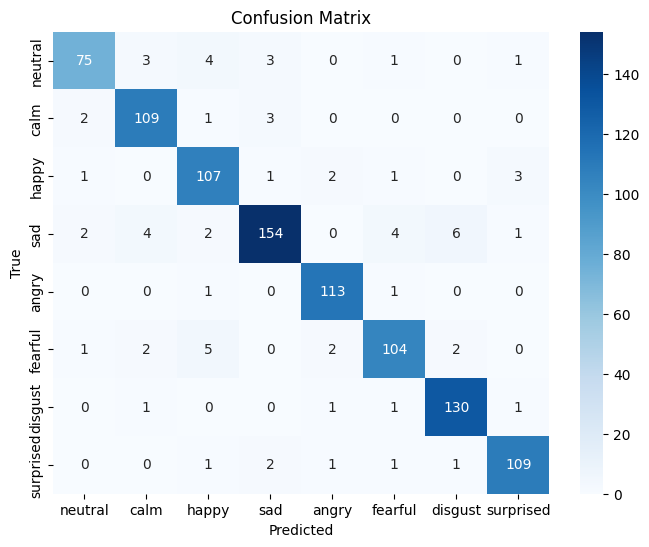


Classification Report:
              precision    recall  f1-score   support

     neutral       0.93      0.86      0.89        87
        calm       0.92      0.95      0.93       115
       happy       0.88      0.93      0.91       115
         sad       0.94      0.89      0.92       173
       angry       0.95      0.98      0.97       115
     fearful       0.92      0.90      0.91       116
     disgust       0.94      0.97      0.95       134
   surprised       0.95      0.95      0.95       115

    accuracy                           0.93       970
   macro avg       0.93      0.93      0.93       970
weighted avg       0.93      0.93      0.93       970



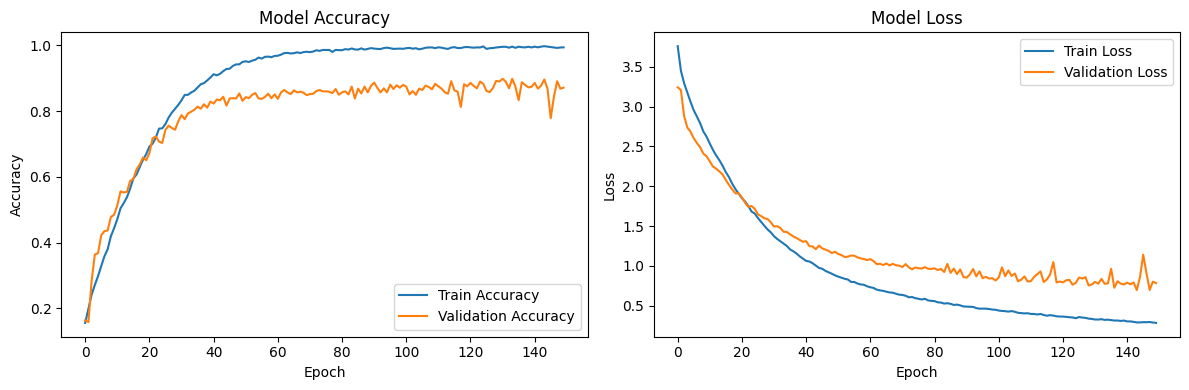

Model saved to 'cnn_lstm_model_optimized_final_v6.h5'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, TimeDistributed, Flatten, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner import RandomSearch
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score
import seaborn as sns

# Tải dữ liệu từ file .npy
X_train = np.load("/content/drive/MyDrive/FPT/DPL_Assignment/X_train.npy")
y_train = np.load("/content/drive/MyDrive/FPT/DPL_Assignment/y_train.npy")
X_val = np.load("/content/drive/MyDrive/FPT/DPL_Assignment/X_val.npy")
y_val = np.load("/content/drive/MyDrive/FPT/DPL_Assignment/y_val.npy")
X_test = np.load("/content/drive/MyDrive/FPT/DPL_Assignment/X_test.npy")
y_test = np.load("/content/drive/MyDrive/FPT/DPL_Assignment/y_test.npy")
print(f"Loaded X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Loaded X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"Loaded X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Kiểm tra tỷ lệ dữ liệu
total_samples = len(y_train) + len(y_val) + len(y_test)
print(f"Total samples: {total_samples}")
print(f"Train percentage: {len(y_train) / total_samples * 100:.1f}%")
print(f"Validation percentage: {len(y_val) / total_samples * 100:.1f}%")
print(f"Test percentage: {len(y_test) / total_samples * 100:.1f}%")

# Tính class weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict[6] *= 0.7  # Giảm trọng số cho "disgust"
class_weight_dict[0] *= 1.3  # Tăng trọng số cho "neutral"
class_weight_dict[2] *= 1.5  # Giữ trọng số cho "happy"
class_weight_dict[3] *= 1.6  # Tăng trọng số cho "sad"

# Hàm xây dựng mô hình
def build_model(hp):
    inputs = Input(shape=(30, 150, 1))  # 30 do có 20 MFCC + 1 RMS + 1 ZCR + 1 Spectral Centroid + 7 Spectral Contrast
    x = Conv2D(hp.Int("filters1", 32, 96, step=32), (3, 3), activation="relu", padding="same",
               kernel_regularizer=l2(hp.Float("l2", 0.005, 0.02, sampling="log")))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(hp.Int("filters2", 64, 128, step=32), (3, 3), activation="relu", padding="same",
               kernel_regularizer=l2(hp.Float("l2", 0.005, 0.02, sampling="log")))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(hp.Int("filters3", 32, 96, step=32), (3, 3), activation="relu", padding="same",
               kernel_regularizer=l2(hp.Float("l2", 0.005, 0.02, sampling="log")))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(hp.Int("lstm_units", 32, 96, step=32), return_sequences=False)(x)
    x = Dropout(hp.Float("dropout", 0.3, 0.5, step=0.1))(x)
    x = Dense(hp.Int("dense_units", 32, 96, step=32), activation="relu",
              kernel_regularizer=l2(hp.Float("l2", 0.005, 0.02, sampling="log")))(x)
    x = BatchNormalization()(x)
    outputs = Dense(8, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(hp.Float("lr", 5e-7, 5e-5, sampling="log")),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Thiết lập callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=15, min_lr=1e-8)

# Tìm kiếm siêu tham số với 10 trials và 10 epochs
tuner = RandomSearch(build_model, objective="val_accuracy", max_trials=10, executions_per_trial=1,
                     directory="tuner_dir", project_name="emotion_tuning_lstm_v6")
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32,  # Giảm epochs xuống 10
             callbacks=[early_stopping, reduce_lr], class_weight=class_weight_dict)

# Lấy cấu hình tốt nhất
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Filters1: {best_hps.get('filters1')}, Filters2: {best_hps.get('filters2')}, Filters3: {best_hps.get('filters3')}")
print(f"LSTM Units: {best_hps.get('lstm_units')}, Dense Units: {best_hps.get('dense_units')}")
print(f"L2: {best_hps.get('l2')}, Dropout: {best_hps.get('dropout')}, Learning Rate: {best_hps.get('lr')}")

# Huấn luyện mô hình với 150 epochs
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=32,
                         callbacks=[early_stopping, reduce_lr], class_weight=class_weight_dict, verbose=1)

# Đánh giá trên tập test
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss (CNN2D + LSTM): {test_loss:.4f}")
print(f"Test Accuracy (CNN2D + LSTM): {test_accuracy:.4f}")

# Kiểm tra overfitting
print(f"Final Train Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
if history.history['accuracy'][-1] - history.history['val_accuracy'][-1] > 0.1:
    print("Warning: Potential overfitting detected (difference > 0.1).")

# Dự đoán và đánh giá chi tiết
y_pred = np.argmax(best_model.predict(X_test), axis=1)
emotion_labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
accuracy = accuracy_score(y_test, y_pred)

print("\nPer-Class Metrics:")
for i, emotion in enumerate(emotion_labels):
    print(f"{emotion}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=emotion_labels))

# Vẽ biểu đồ
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Lưu mô hình
best_model.save("cnn_lstm_model_optimized_final_v6.h5")
print("Model saved to 'cnn_lstm_model_optimized_final_v6.h5'")